In [34]:
# Import library yang kalian butuhkan
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
import seaborn as sns

| Library                             | Fungsi / Kegunaan                                                                                              |
| ------------------------------------------- | -------------------------------------------------------------------------------------------------------------- |
| `os`                                        | Untuk berinteraksi dengan sistem file (misalnya membaca nama file, direktori, dll).                            |
| `cv2 (OpenCV)`                              | Digunakan untuk pemrosesan citra seperti membaca gambar, mengubah warna, dll.                                  |
| `matplotlib.pyplot`                         | Untuk visualisasi data, khususnya dalam bentuk grafik atau gambar.                                             |
| `numpy`                                     | Library numerik untuk perhitungan array dan operasi matematis tingkat lanjut.                                  |
| `pandas`                                    | Digunakan untuk manipulasi dan analisis data dalam bentuk tabel (DataFrame).                                   |
| `sklearn.model_selection.train_test_split`  | Membagi dataset menjadi data latih dan data uji.                                                               |
| `sklearn.model_selection.cross_val_predict` | Melakukan prediksi silang (cross-validation) untuk evaluasi model.                                             |
| `sklearn.metrics`                           | Menghitung metrik evaluasi model seperti akurasi, precision, recall, F1-score, confusion matrix, dll.          |
| `skimage.feature.graycomatrix`              | Menghitung *Gray-Level Co-Occurrence Matrix (GLCM)* dari citra grayscale.                                      |
| `skimage.feature.graycoprops`               | Mengambil properti statistik dari GLCM seperti kontras, homogenitas, dll.                                      |
| `scipy.stats.entropy`                       | Menghitung nilai entropi (ukuran ketidakteraturan) dari data.                                                  |
| `sklearn.ensemble.RandomForestClassifier`   | Algoritma klasifikasi berbasis ensemble decision trees.                                                        |
| `sklearn.svm.SVC`                           | Support Vector Classifier untuk klasifikasi data dengan margin maksimum.                                       |
| `sklearn.neighbors.KNeighborsClassifier`    | Algoritma klasifikasi berbasis tetangga terdekat.                                                              |
| `seaborn`                                   | Library visualisasi berbasis matplotlib yang lebih interaktif dan estetis, cocok untuk heatmap, pairplot, dsb. |


## Data Loading

Buat struktur folder dataset sebagai berikut:
```
.
└──dataset
    ├── label1
	├── image1.jpg
	├── image2.jpg
	└── image3.jpg
    ├── label2
    └── label3
    └── dst...
```

In [35]:
def resize_image(img_path, size):
    try:
        img = cv.imread(img_path)
        if img is None:
            raise ValueError(f"Image at {img_path} could not be read.")
        resized_img = cv.resize(img, size)
        return resized_img
    except Exception as e:
        print(f"Error resizing image {img_path}: {e}")
        return None

Fungsi resize_image(img_path, size) bertujuan untuk mengubah ukuran gambar sesuai dimensi yang diberikan. Fungsi ini mencoba membaca gambar dari path yang diberikan menggunakan cv.imread(img_path), dan jika gambar tidak dapat dibaca (mengembalikan None), maka akan memunculkan exception ValueError. Jika berhasil, gambar tersebut diubah ukurannya menggunakan cv.resize(img, size) dan hasilnya dikembalikan. Jika terjadi kesalahan selama proses ini, pesan error akan dicetak dan fungsi mengembalikan None.

Fungsi load_dataset(dir) digunakan untuk memuat dataset gambar dari folder utama yang berisi subfolder kelas, masing-masing mewakili label. Setiap gambar diresize ke ukuran (256, 256) menggunakan fungsi resize_image, kemudian dimasukkan ke dalam list images, sedangkan labelnya dimasukkan ke list labels. Fungsi ini membatasi maksimal 100 gambar per kelas untuk mencegah ketidakseimbangan data dan mencatat jumlah gambar tiap kelas dalam dictionary class_counter. Setelah semua gambar dibaca, fungsi mengembalikan array NumPy dari gambar dan label, daftar nama kelas, serta informasi jumlah gambar per kelas. Di bagian akhir, dataset dimuat dari folder 'dataset' dan divisualisasikan menggunakan seaborn dalam bentuk diagram batang yang menunjukkan distribusi jumlah gambar per kelas, lalu disimpan sebagai gambar 'dataset_distribution.png'.

Loading dataset...
Dataset loaded with 270 images across 3 classes.


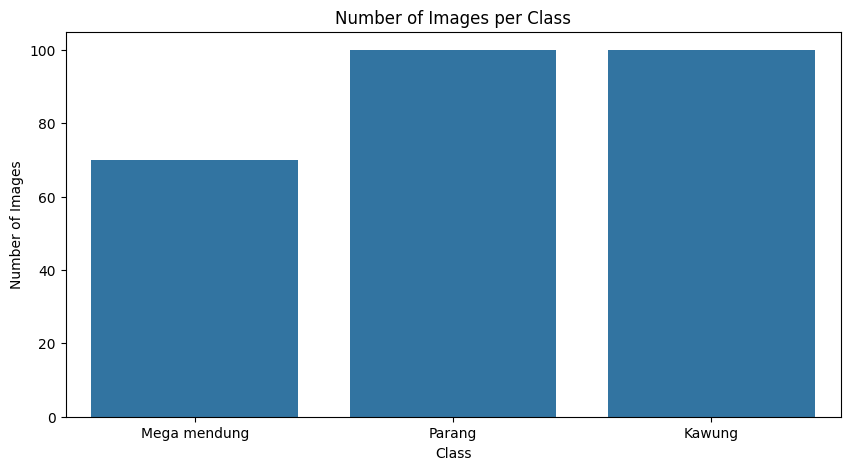

In [36]:
def load_dataset(dir):
    size = (256,256)
    images = []
    labels = []
    class_names = os.listdir(dir)
    class_counter = {class_name: 0 for class_name in class_names}

    for label, class_name in enumerate(class_names):
        class_dir = os.path.join(dir, class_name)
        if os.path.isdir(class_dir):
            for file_name in os.listdir(class_dir):
                if class_counter[class_name] >= 100:
                    break
                img_path = os.path.join(class_dir, file_name)
                img = resize_image(img_path, size)
                if img is not None:
                    images.append(img)
                    labels.append(class_name)
                    class_counter[class_name]+=1
    return np.array(images), np.array(labels), class_names, class_counter


print("Loading dataset...")
images, labels, class_names, class_counter = load_dataset('dataset')
print(f"Dataset loaded with {len(images)} images across {len(class_names)} classes.")
# Diagram Dataset
plt.figure(figsize=(10, 5))
sns.barplot(x=list(class_counter.keys()), y=list(class_counter.values()))
plt.title('Number of Images per Class')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.savefig('dataset_distribution.png')
plt.show()

Fungsi show_sample_images(images, labels, class_names) digunakan untuk menampilkan satu gambar contoh dari setiap kelas dalam dataset. Dengan menggunakan matplotlib, fungsi ini membuat sebuah figure berukuran 15x10 inci dan untuk setiap kelas, gambar ke-10 dari kumpulan gambar yang memiliki label sesuai nama kelas diambil dan ditampilkan setelah dikonversi dari format BGR ke RGB menggunakan cv.cvtColor. Judul setiap subplot menunjukkan nama kelas, dan axis disembunyikan agar tampilan lebih bersih. Fungsi ini membantu memverifikasi visualisasi representatif dari masing-masing kelas dalam dataset.

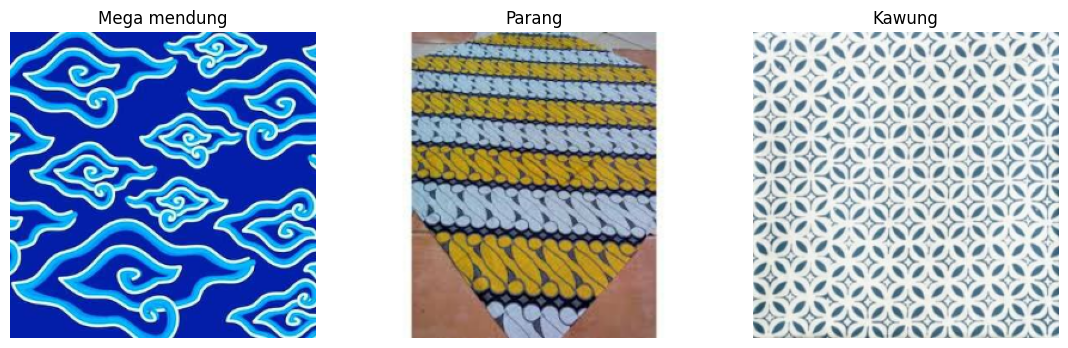

In [37]:
# Menampilkan gambar sample dari setiap kelas
def show_sample_images(images, labels, class_names):
    plt.figure(figsize=(15, 10))
    for i, class_name in enumerate(class_names):
        class_images = images[labels == class_name]
        if len(class_images) > 0:
            plt.subplot(3, 4, i + 1)
            plt.imshow(cv.cvtColor(class_images[10], cv.COLOR_BGR2RGB))
            plt.title(class_name)
            plt.axis('off')
    plt.tight_layout()
    plt.show()
show_sample_images(images, labels, class_names)

Kode ini mengubah semua gambar berwarna di images menjadi versi grayscale menggunakan cv.cvtColor dengan konversi COLOR_BGR2GRAY, lalu menyimpannya dalam list img_grey. Setelah semua gambar diproses, list tersebut diubah menjadi array NumPy. Kemudian, fungsi show_sample_images dipanggil untuk menampilkan gambar contoh dari setiap kelas, tapi kali ini gambar yang ditampilkan adalah versi grayscale-nya. Jadi, ini memvisualisasikan sampel gambar dalam format hitam-putih per kelas.

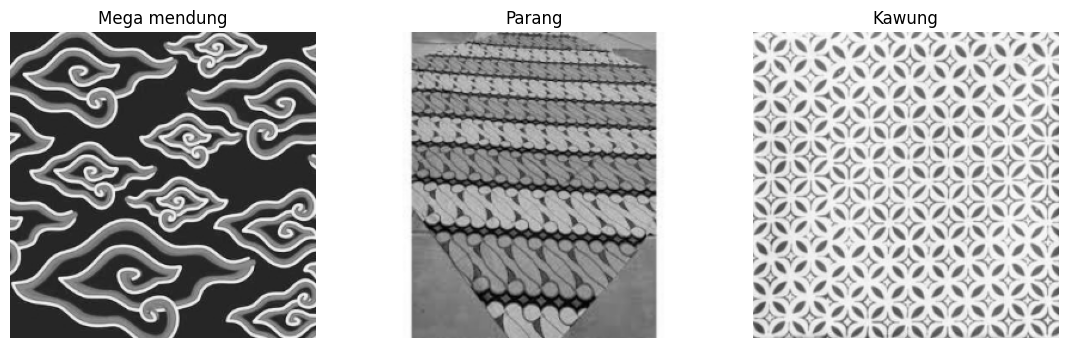

In [38]:
img_grey = []
for img in images:
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    img_grey.append(gray)
img_grey = np.array(img_grey)

show_sample_images(img_grey, labels, class_names)

### **PreProcessing 1**

In [39]:
# # Kernel Sobel
# Sx = np.array([[-1, 0, 1],
#                [-2, 0, 2],
#                [-1, 0, 1]])

# Sy = np.array([[1,  2,  1],
#                [0,  0,  0],
#                [-1, -2, -1]])

# def padding_baris(image):
#     height, width = image.shape
#     img_pad = np.zeros((height, width + 1))
#     img_pad[:, :width] = image
#     return img_pad

# def padding_kolom(image):
#     height, width = image.shape
#     img_pad = np.zeros((height + 1, width))
#     img_pad[:height, :] = image
#     return img_pad

# # Fungsi konvolusi edge
# def convo_edge(image, kernel, jenis):
#     img_height, img_width = image.shape
#     k_height, k_width = kernel.shape
#     p_height, p_width = k_height // 2, k_width // 2

#     if jenis.lower() != "roberts":
#         padded_img = np.pad(image, ((p_height, p_height), (p_width, p_width)), mode='reflect')
#     else:
#         padded_img = padding_kolom(padding_baris(image))

#     result = np.zeros((img_height, img_width))

#     for i in range(img_height):
#         for j in range(img_width):
#             region = padded_img[i:i + k_height, j:j + k_width]
#             result[i, j] = np.sum(region * kernel)

#     return result

# # Fungsi deteksi tepi
# def deteksi_tepi(image, kernelX, kernelY, jenis):
#     hasilX = convo_edge(image, kernelX, jenis)
#     hasilY = convo_edge(image, kernelY, jenis)
#     magnitude = np.sqrt(hasilX**2 + hasilY**2)
#     return np.clip(magnitude, 0, 255).astype(np.uint8)

# # Proses ke semua gambar
# img_sobel = []
# for img in img_grey:
#     sobel = deteksi_tepi(img, Sx, Sy, jenis="sobel")
#     img_sobel.append(sobel)
# img_sobel = np.array(img_sobel)

# # Tampilkan sample gambar
# show_sample_images(img_sobel, labels, class_names)


In [ ]:
# #Fungsi Sharpening
# def sharpen_image(image):
#     kernel = np.array([[1/9,1/9,1/9],
#                              [1/9,8/9,1/9],
#                              [1/9,1/9,1/9]])
#     sharpened = cv.filter2D(image, -1, kernel)
#     return sharpened
# # Melakukan sharpening pada gambar
# img_sharpened = []
# for img in img_sobel:
#     sharpened = sharpen_image(img)
#     img_sharpened.append(sharpened)
# img_sharpened = np.array(img_sharpened)
# show_sample_images(img_sharpened, labels, class_names)

### Feature Extraction

In [41]:
def glcm(image, derajat):
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")

    # mengembalikan matrix glcm dari image
    glcm = graycomatrix(image, [1], angles, 256, symmetric=True, normed=True)
    return glcm

Fungsi glcm(image, derajat) menghasilkan matriks GLCM (Gray Level Co-occurrence Matrix) dari gambar grayscale berdasarkan sudut tertentu yang dipilih dari 0°, 45°, 90°, atau 135°. Fungsi ini mengubah input sudut (derajat) menjadi radian yang sesuai untuk parameter graycomatrix dari library skimage.feature. Matriks GLCM dihitung dengan jarak piksel 1, dalam arah sudut yang ditentukan, dengan 256 tingkat abu-abu, dan menggunakan opsi simetri serta normalisasi agar hasil matriks bersifat simetris dan probabilistik. Matriks GLCM ini penting untuk mengekstrak fitur tekstur dari gambar dalam analisis citra.

In [42]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]

Fungsi correlation(matriks) mengambil sebuah matriks GLCM sebagai input dan mengembalikan nilai korelasi tekstur yang dihitung menggunakan fungsi graycoprops dari skimage.feature. Korelasi ini mengukur sejauh mana nilai pixel dalam gambar saling terkait secara linear pada pola tekstur tertentu. Fungsi mengakses elemen [0, 0] dari hasil graycoprops karena GLCM yang dihasilkan biasanya dalam bentuk 4D, dan di sini fokus hanya pada nilai korelasi pertama. Nilai korelasi ini berguna untuk menganalisis hubungan spasial antar pixel dalam gambar.

In [43]:
def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]

Fungsi dissimilarity(matriks) menerima matriks GLCM sebagai input dan mengembalikan nilai dissimilarity tekstur menggunakan fungsi graycoprops dari skimage.feature. Nilai dissimilarity mengukur seberapa berbeda intensitas pixel yang berdekatan dalam gambar, memberikan informasi tentang variasi tekstur. Sama seperti fungsi korelasi, hasilnya diakses pada indeks [0, 0] karena GLCM biasanya berformat 4D. Nilai ini berguna untuk memahami tingkat ketidaksamaan lokal dalam pola tekstur gambar.

In [44]:
def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]

Fungsi homogenity(matriks) menerima matriks GLCM dan mengembalikan nilai homogeneity (keseragaman) tekstur yang dihitung menggunakan graycoprops dari skimage.feature. Nilai ini mengukur seberapa seragam atau konsisten tekstur dalam gambar, dengan nilai tinggi menunjukkan tekstur yang lebih halus dan seragam. Sama seperti sebelumnya, hasilnya diambil pada indeks [0, 0] karena format matriks GLCM. Fitur homogenity ini penting untuk analisis pola tekstur dalam citra.

In [45]:
def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]

Fungsi contrast(matriks) menerima matriks GLCM sebagai input dan mengembalikan nilai contrast tekstur yang dihitung dengan graycoprops dari skimage.feature. Nilai contrast mengukur tingkat variasi intensitas antar pixel dalam gambar, di mana nilai tinggi menunjukkan perbedaan intensitas yang lebih tajam atau tekstur yang lebih kasar. Hasil diambil dari indeks [0, 0] sesuai format matriks GLCM. Fitur ini berguna untuk menilai tingkat ketajaman atau perubahan pola pada gambar.

In [46]:
def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]

Fungsi ASM(matriks) menerima matriks GLCM dan mengembalikan nilai Angular Second Moment (ASM) atau energy tekstur menggunakan graycoprops dari skimage.feature. Nilai ASM mengukur konsentrasi atau keteraturan pola tekstur dalam gambar; nilai tinggi menunjukkan tekstur yang lebih seragam dan teratur. Seperti fungsi lain, hasilnya diambil dari indeks [0, 0] karena format matriks GLCM. ASM sering digunakan untuk menilai homogenitas dan kekuatan pola tekstur.

In [47]:
def energy(matriks):
    return graycoprops(matriks, 'energy')[0, 0]

Fungsi energy(matriks) menerima matriks GLCM sebagai input dan mengembalikan nilai energy tekstur yang dihitung dengan graycoprops dari skimage.feature. Energy merupakan akar kuadrat dari Angular Second Moment (ASM) dan mengukur kekuatan atau intensitas pola tekstur dalam gambar, dengan nilai tinggi menunjukkan tekstur yang lebih konsisten dan teratur. Hasil diambil dari indeks [0, 0] sesuai format matriks GLCM. Fitur energy ini penting untuk analisis kekuatan pola dalam citra.


In [48]:
def entropyGlcm(matriks):
    return entropy(matriks.ravel())

Fungsi entropyGlcm(matriks) menghitung entropi dari matriks GLCM yang diberikan dengan terlebih dahulu meratakan matriks tersebut menjadi satu dimensi menggunakan .ravel(), lalu menerapkan fungsi entropy dari modul scipy.stats atau sejenisnya. Entropi mengukur tingkat ketidakpastian atau kompleksitas tekstur dalam gambar; nilai entropi yang tinggi menunjukkan pola tekstur yang lebih acak atau kompleks. Fungsi ini berguna untuk menilai keragaman dan keacakan fitur tekstur pada citra.

In [49]:
Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(img_grey)):
    D0 = glcm(img_grey[i], 0)
    D45 = glcm(img_grey[i], 45)
    D90 = glcm(img_grey[i], 90)
    D135 = glcm(img_grey[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

Kode ini menghitung matriks GLCM untuk setiap gambar hasil sharpening (img_sharpened) pada empat sudut berbeda: 0°, 45°, 90°, dan 135°. Dalam setiap iterasi, fungsi glcm dipanggil dengan gambar ke-i dan sudut yang berbeda, lalu hasil matriks GLCM tersebut disimpan secara terpisah dalam list Derajat0, Derajat45, Derajat90, dan Derajat135. Dengan begitu, setiap gambar memiliki empat matriks GLCM yang mewakili tekstur dari berbagai arah, yang bisa digunakan untuk ekstraksi fitur tekstur lebih lanjut.

In [50]:
Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []


Kode ini mendefinisikan 24 list kosong yang akan digunakan untuk menyimpan nilai fitur tekstur hasil ekstraksi dari matriks GLCM di empat arah sudut berbeda (0°, 45°, 90°, dan 135°). Setiap fitur — seperti contrast, dissimilarity, homogeneity, entropy, ASM, energy, dan correlation — memiliki empat list terpisah sesuai sudutnya, misalnya Kontras0 untuk sudut 0°, Kontras45 untuk sudut 45°, dan seterusnya. List-list ini nantinya akan diisi dengan nilai fitur tekstur dari tiap gambar sebagai bagian dari proses ekstraksi fitur tekstur citra.

In [51]:
for i in range(len(img_grey)):
    C0 = correlation(Derajat0[i])
    correlation0.append(C0)
    C45 = correlation(Derajat45[i])
    correlation45.append(C45)
    C90 = correlation(Derajat90[i])
    correlation90.append(C90)
    C135 = correlation(Derajat135[i])
    correlation135.append(C135)

Kode ini melakukan perulangan untuk setiap gambar hasil sharpening (img_sharpened) dan menghitung fitur korelasi tekstur dari matriks GLCM yang sudah disimpan sebelumnya pada masing-masing sudut (0°, 45°, 90°, dan 135°) menggunakan fungsi correlation(). Nilai korelasi yang dihitung untuk tiap sudut kemudian disimpan ke dalam list yang sesuai: correlation0, correlation45, correlation90, dan correlation135. Dengan cara ini, fitur korelasi tekstur dari semua gambar di semua arah tersimpan terpisah untuk analisis atau pemrosesan lebih lanjut.

In [52]:
for i in range(len(img_grey)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)

Kode ini melakukan perulangan untuk setiap gambar hasil sharpening (img_sharpened) dan menghitung fitur korelasi tekstur dari matriks GLCM yang sudah disimpan sebelumnya pada masing-masing sudut (0°, 45°, 90°, dan 135°) menggunakan fungsi correlation(). Nilai korelasi yang dihitung untuk tiap sudut kemudian disimpan ke dalam list yang sesuai: correlation0, correlation45, correlation90, dan correlation135. Dengan cara ini, fitur korelasi tekstur dari semua gambar di semua arah tersimpan terpisah untuk analisis atau pemrosesan lebih lanjut.

In [53]:
for i in range(len(img_grey)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)

Kode ini melakukan perulangan untuk setiap gambar hasil sharpening dan menghitung fitur dissimilarity dari matriks GLCM yang sudah dihitung pada empat sudut (0°, 45°, 90°, 135°) menggunakan fungsi dissimilarity(). Nilai yang diperoleh untuk tiap sudut disimpan ke dalam list yang sesuai (dissimilarity0, dissimilarity45, dissimilarity90, dan dissimilarity135). Dengan cara ini, fitur dissimilarity tekstur untuk semua gambar dan arah tersimpan untuk analisis lebih lanjut.

In [54]:
for i in range(len(img_grey)):
    H0 = homogenity(Derajat0[i])
    H45 = homogenity(Derajat45[i])
    H90 = homogenity(Derajat90[i])
    H135 = homogenity(Derajat135[i])
    homogenity0.append(H0)
    homogenity45.append(H45)
    homogenity90.append(H90)
    homogenity135.append(H135)

Kode ini menghitung fitur homogeneity (keseragaman tekstur) untuk setiap gambar hasil sharpening dengan memanfaatkan matriks GLCM pada empat sudut berbeda (0°, 45°, 90°, 135°) menggunakan fungsi homogenity(). Nilai homogeneity yang dihasilkan untuk tiap sudut disimpan masing-masing ke dalam list homogenity0, homogenity45, homogenity90, dan homogenity135. Ini memungkinkan analisis keseragaman tekstur gambar dari berbagai arah secara terpisah.

In [55]:
for i in range(len(img_grey)):
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)

Kode ini menghitung nilai entropi tekstur dari setiap gambar hasil sharpening berdasarkan matriks GLCM pada empat sudut (0°, 45°, 90°, dan 135°) menggunakan fungsi entropyGlcm(). Nilai entropi yang diperoleh untuk tiap sudut kemudian disimpan ke dalam list entropy0, entropy45, entropy90, dan entropy135. Entropi ini mengukur kompleksitas atau kerandoman tekstur dari gambar di berbagai arah, yang penting untuk analisis pola tekstur.

In [56]:
for i in range(len(img_grey)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)

Kode ini melakukan iterasi untuk setiap gambar hasil sharpening dan menghitung fitur Angular Second Moment (ASM) dari matriks GLCM pada empat sudut berbeda (0°, 45°, 90°, dan 135°) menggunakan fungsi ASM(). Nilai ASM yang diperoleh untuk masing-masing sudut disimpan ke dalam list ASM0, ASM45, ASM90, dan ASM135. ASM ini mengukur keteraturan dan homogenitas pola tekstur dalam gambar, sehingga penting untuk analisis tekstur yang mendalam.

In [57]:
for i in range(len(img_grey)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)

Kode ini melakukan perulangan pada setiap gambar hasil sharpening dan menghitung fitur energy tekstur dari matriks GLCM pada empat sudut berbeda (0°, 45°, 90°, dan 135°) dengan menggunakan fungsi energy(). Nilai energy yang diperoleh kemudian disimpan secara terpisah dalam list energy0, energy45, energy90, dan energy135. Fitur energy ini menggambarkan kekuatan dan konsistensi pola tekstur pada citra di berbagai arah.

### Write the extraction's results to CSV

In [58]:
dataTable = {'Filename': [f'Image_{i+1}' for i in range(len(img_grey))],
        'Class': labels,
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }
df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi_pros1.csv', index=False)

hasilEkstrak = pd.read_csv('hasil_ekstraksi_pros1.csv')
hasilEkstrak = hasilEkstrak.drop(columns=['Filename'])
x = hasilEkstrak.drop(columns=['Class'])
y = hasilEkstrak['Class']


Kode ini membuat sebuah dictionary dataTable yang berisi semua fitur tekstur hasil ekstraksi dari gambar, termasuk nama file (diberi label Image_1, Image_2, dst), kelas label, dan semua fitur GLCM pada keempat sudut (0°, 45°, 90°, 135°) seperti contrast, homogeneity, dissimilarity, entropy, ASM, energy, dan correlation. Dictionary ini kemudian diubah menjadi DataFrame pandas dan disimpan ke file CSV bernama hasil_ekstraksi_pros1.csv. Selanjutnya, file CSV tersebut dibaca kembali ke variabel hasilEkstrak, kolom Filename dihapus karena tidak diperlukan untuk analisis, lalu data fitur disimpan ke x dan label kelas ke y untuk persiapan pemodelan atau analisis lebih lanjut.

### Features Selection

pada bagian seleksi fitur ini bisa menggunakan metode seperti
- PCA
- LDA
- t-SNE
- Chi-square
- ANOVA
- Autoencoder
- correlation
- dll

berikut contoh menggunakan correlation:

Kode ini menghitung matriks korelasi antar fitur pada dataset x menggunakan x.corr(). Hasil korelasi tersebut divisualisasikan dengan heatmap menggunakan seaborn (sns.heatmap), yang menampilkan nilai korelasi antar fitur dalam format dua desimal, menggunakan skema warna coolwarm untuk memperjelas hubungan positif dan negatif antar fitur. Heatmap dibuat dalam ukuran besar (20x16 inci), diberi judul "Correlation Matrix", kemudian disimpan sebagai file gambar correlation_matrix1.png, dan terakhir ditampilkan di layar. Visualisasi ini membantu memahami sejauh mana fitur-fitur saling berkaitan satu sama lain.

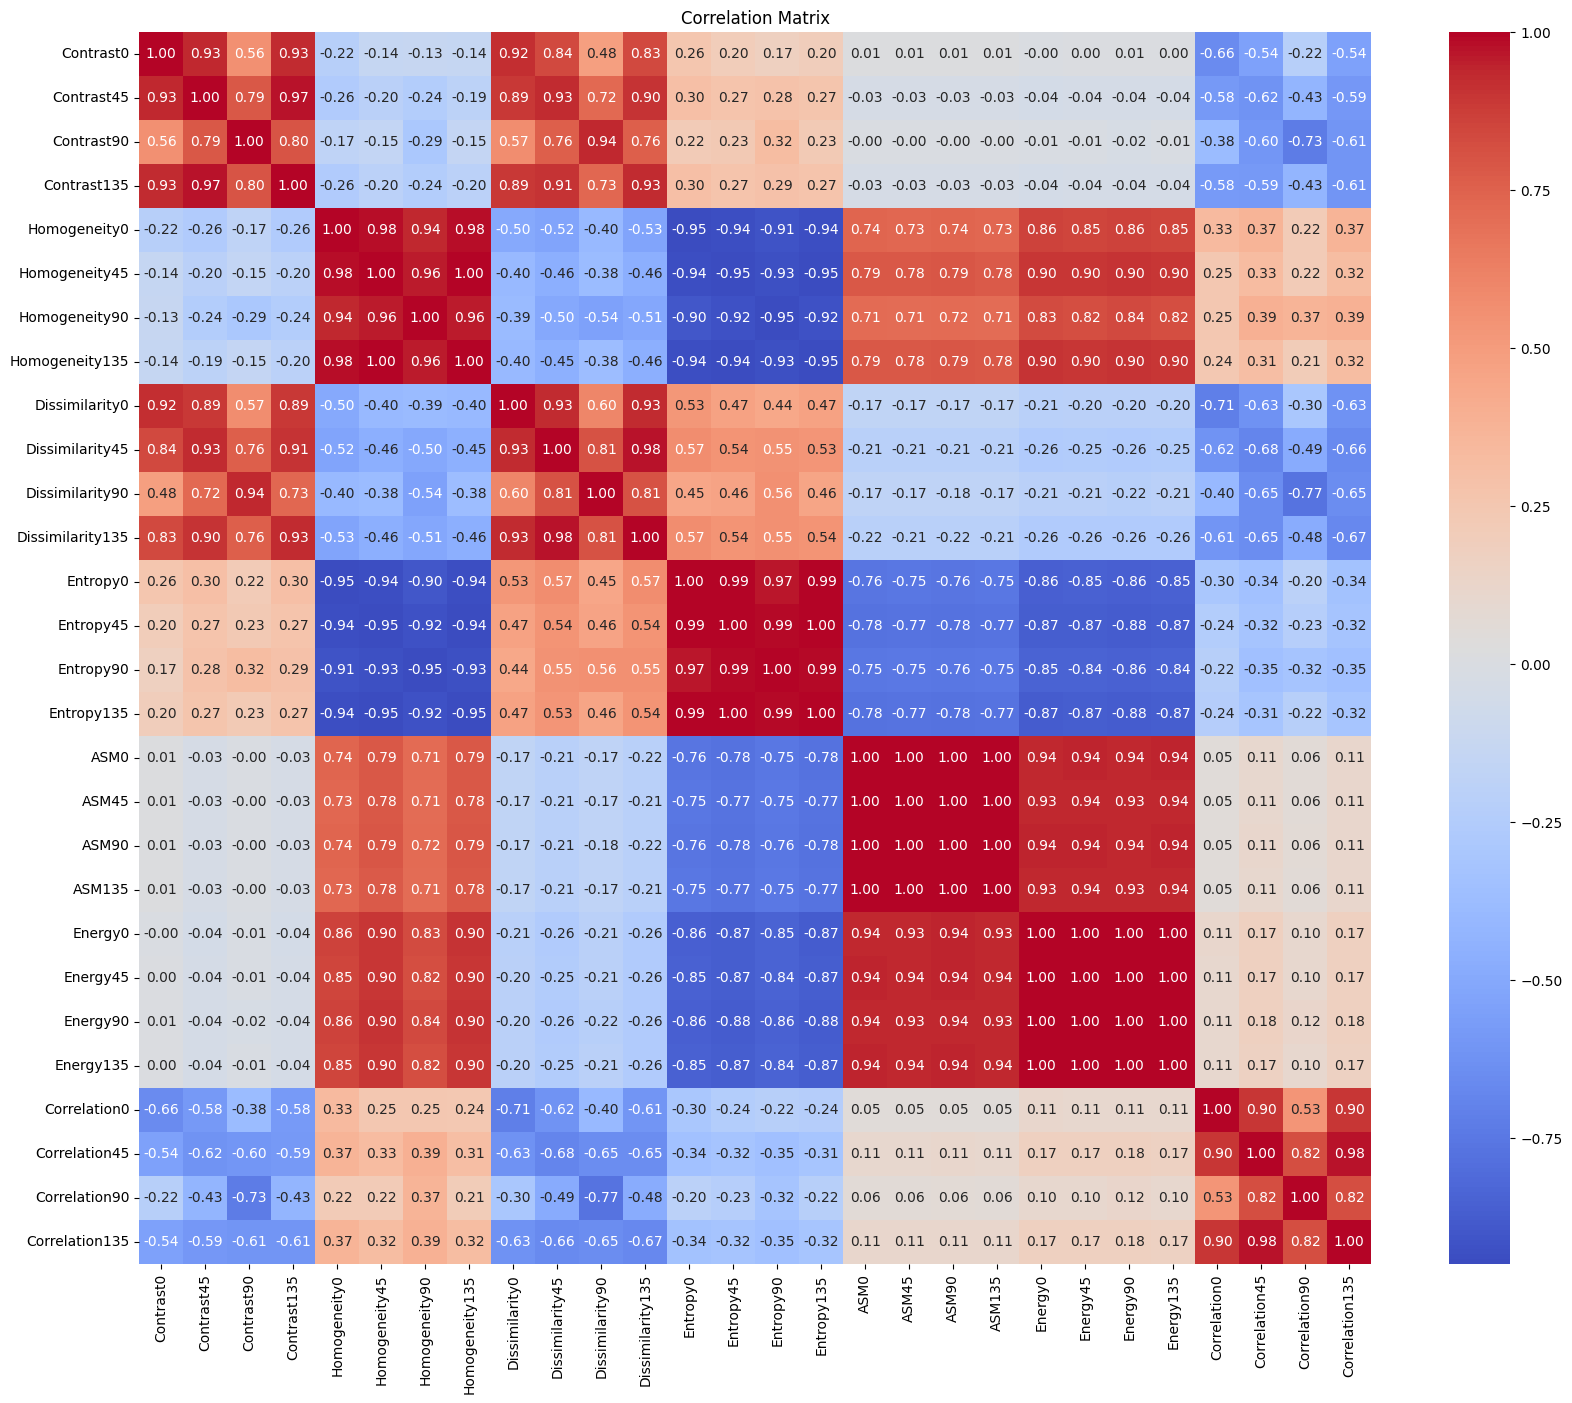

In [59]:
# Menghitung Korelasi
correlation_matrix = x.corr()
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Matrix')
plt.savefig('correlation_matrix1.png')
plt.show()

## Splitting Data

In [60]:
# ubah bagian test_size sesuai kebutuhan
# 0.3 = 30% data untuk testing (train/test 70/30)
# 0.2 = 20% data untuk testing (train/test 80/20)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
print(f"Training set size: {len(x_train)}, Test set size: {len(x_test)}")
print(f"Training set size: {len(y_train)}, Test set size: {len(y_test)}")


Training set size: 189, Test set size: 81
Training set size: 189, Test set size: 81


Kode ini membagi dataset fitur x dan label y menjadi dua bagian: data pelatihan (training) dan data pengujian (testing) menggunakan fungsi train_test_split dari sklearn.model_selection. Parameter test_size=0.3 berarti 30% data digunakan untuk testing, dan sisanya 70% untuk training. random_state=42 digunakan agar pembagian data selalu konsisten ketika kode dijalankan ulang. Setelah pembagian, ukuran dataset training dan testing untuk fitur (x_train, x_test) serta label (y_train, y_test) dicetak ke layar agar dapat dilihat. Ini penting untuk persiapan model machine learning.

## Feature Normalization

berikut metode normalisasi yang bisa digunakan:
- Min-Max Scaling
- Standardization (Z-score)
- Robust Scaling
- MaxAbsScaler
- dll

berikut contoh menggunakan Standardization (Z-score):

In [61]:
# normalisasi mean std
def normalize_data(data):
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    normalized_data = (data - mean) / std
    return normalized_data
x_train = normalize_data(x_train)
x_test = normalize_data(x_test)

Kode ini mendefinisikan fungsi normalize_data untuk melakukan normalisasi data dengan metode standardization—yaitu mengubah data sehingga memiliki rata-rata (mean) 0 dan standar deviasi (std) 1 pada setiap fitur. Fungsi ini menghitung rata-rata dan standar deviasi kolom per kolom pada data, lalu mengurangi mean dan membagi dengan std untuk setiap elemen. Setelah fungsi didefinisikan, normalisasi diterapkan pada data training (x_train) dan data testing (x_test)

## Modeling

### Define Model

In [62]:
def generateClassificationReport(y_true, y_pred):
	print(classification_report(y_true, y_pred))
	print(confusion_matrix(y_true, y_pred))
	print('Accuracy:', accuracy_score(y_true, y_pred))

# Define classifiers
rf = RandomForestClassifier(n_estimators=5, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

Kode ini mendefinisikan fungsi generateClassificationReport yang menerima label asli (y_true) dan prediksi model (y_pred), kemudian mencetak tiga metrik evaluasi: laporan klasifikasi lengkap (classification_report) yang berisi precision, recall, f1-score per kelas; matriks kebingungan (confusion_matrix) yang menunjukkan distribusi prediksi benar/salah; dan akurasi keseluruhan (accuracy_score).

Selanjutnya, kode juga mendefinisikan tiga model klasifikasi yang akan digunakan:

    rf: Random Forest dengan 5 pohon keputusan (n_estimators=5) dan seed acak 42 untuk konsistensi hasil,

    svm: Support Vector Machine dengan kernel Radial Basis Function (RBF),

    knn: K-Nearest Neighbors dengan 5 tetangga terdekat.

Model-model ini nantinya bisa dilatih dan diuji pada data yang sudah disiapkan.

### Train Random Forest Classifier

In [63]:
# Train Random Forest Classifier
rf.fit(x_train, y_train)

# Make predictions and evaluate the model with the training set
print("------Training Set------")
y_pred = rf.predict(x_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = rf.predict(x_test)
generateClassificationReport( y_test, y_pred)

------Training Set------
              precision    recall  f1-score   support

      Kawung       0.93      0.93      0.93        71
Mega mendung       0.92      0.94      0.93        48
      Parang       0.96      0.94      0.95        70

    accuracy                           0.94       189
   macro avg       0.93      0.94      0.94       189
weighted avg       0.94      0.94      0.94       189

[[66  3  2]
 [ 2 45  1]
 [ 3  1 66]]
Accuracy: 0.9365079365079365

------Testing Set------
              precision    recall  f1-score   support

      Kawung       0.52      0.48      0.50        29
Mega mendung       0.43      0.45      0.44        22
      Parang       0.55      0.57      0.56        30

    accuracy                           0.51        81
   macro avg       0.50      0.50      0.50        81
weighted avg       0.51      0.51      0.51        81

[[14  6  9]
 [ 7 10  5]
 [ 6  7 17]]
Accuracy: 0.5061728395061729


Kode ini melatih model Random Forest (rf) menggunakan data training x_train dan y_train dengan memanggil fit(). Setelah itu, model digunakan untuk memprediksi kelas pada data training (x_train) dan hasil prediksi tersebut dibandingkan dengan label asli y_train untuk mengevaluasi performa model pada data pelatihan, dengan hasil evaluasi dicetak menggunakan fungsi generateClassificationReport.

Kemudian, model juga diuji pada data testing (x_test), dengan prediksi dibandingkan terhadap label asli y_test, untuk menilai performa model pada data yang belum pernah dilihat sebelumnya. Evaluasi testing ini juga ditampilkan dengan laporan klasifikasi, matriks kebingungan, dan akurasi agar dapat menilai kemampuan generalisasi model.

### Train SVM Classifier

In [64]:
# Train SVM Classifier
svm.fit(x_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = svm.predict(x_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = svm.predict(x_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
              precision    recall  f1-score   support

      Kawung       0.54      0.61      0.57        71
Mega mendung       0.78      0.29      0.42        48
      Parang       0.60      0.79      0.68        70

    accuracy                           0.59       189
   macro avg       0.64      0.56      0.56       189
weighted avg       0.62      0.59      0.57       189

[[43  2 26]
 [23 14 11]
 [13  2 55]]
Accuracy: 0.5925925925925926

------Testing Set------
              precision    recall  f1-score   support

      Kawung       0.58      0.66      0.61        29
Mega mendung       0.54      0.32      0.40        22
      Parang       0.63      0.73      0.68        30

    accuracy                           0.59        81
   macro avg       0.58      0.57      0.56        81
weighted avg       0.59      0.59      0.58        81

[[19  2  8]
 [10  7  5]
 [ 4  4 22]]
Accuracy: 0.5925925925925926


Kode di atas digunakan untuk melatih dan mengevaluasi model klasifikasi Support Vector Machine (SVM) dengan kernel Radial Basis Function (RBF). Pertama, model SVM dilatih menggunakan data pelatihan (x_train dan y_train) melalui metode .fit(). Setelah model dilatih, evaluasi dilakukan dalam dua tahap, yaitu terhadap data pelatihan dan data pengujian. Pada tahap evaluasi pertama, prediksi dilakukan terhadap data pelatihan menggunakan metode .predict() dan hasilnya dibandingkan dengan label sebenarnya untuk menilai apakah model mengalami overfitting, yaitu jika akurasi pada data pelatihan sangat tinggi namun rendah pada data pengujian. Selanjutnya, evaluasi dilakukan terhadap data pengujian untuk mengukur kemampuan generalisasi model terhadap data baru yang belum pernah dilihat sebelumnya. Hasil evaluasi ditampilkan dalam bentuk classification report yang mencakup precision, recall, dan F1-score untuk setiap kelas, serta confusion matrix yang menunjukkan jumlah prediksi benar dan salah, dan akurasi keseluruhan model. Evaluasi ini penting untuk mengetahui seberapa baik model SVM dalam mengklasifikasikan citra berdasarkan fitur yang telah diekstraksi sebelumnya.

### Train KNN Classifier

In [65]:
# Train KNN Classifier
knn.fit(x_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = knn.predict(x_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = knn.predict(x_test)
generateClassificationReport( y_test, y_pred)



------Training Set------
              precision    recall  f1-score   support

      Kawung       0.55      0.72      0.63        71
Mega mendung       0.65      0.54      0.59        48
      Parang       0.79      0.64      0.71        70

    accuracy                           0.65       189
   macro avg       0.66      0.63      0.64       189
weighted avg       0.67      0.65      0.65       189

[[51 10 10]
 [20 26  2]
 [21  4 45]]
Accuracy: 0.6455026455026455

------Testing Set------
              precision    recall  f1-score   support

      Kawung       0.53      0.66      0.58        29
Mega mendung       0.47      0.32      0.38        22
      Parang       0.67      0.67      0.67        30

    accuracy                           0.57        81
   macro avg       0.55      0.55      0.54        81
weighted avg       0.56      0.57      0.56        81

[[19  4  6]
 [11  7  4]
 [ 6  4 20]]
Accuracy: 0.5679012345679012


Kode di atas digunakan untuk melatih dan mengevaluasi model klasifikasi K-Nearest Neighbors (KNN). Model KNN dilatih dengan data pelatihan x_train dan label y_train menggunakan metode .fit(), meskipun secara teknis KNN tidak benar-benar melakukan pelatihan dalam arti tradisional—melainkan menyimpan data pelatihan untuk digunakan saat prediksi. Setelah itu, prediksi dilakukan terhadap data pelatihan dan data pengujian menggunakan metode .predict(). Evaluasi hasil prediksi dilakukan menggunakan fungsi generateClassificationReport, yang mencetak classification report (berisi precision, recall, dan F1-score), confusion matrix, dan nilai akurasi. Evaluasi terhadap data pelatihan menunjukkan seberapa baik KNN mengenali pola dari data yang sudah diketahui, sedangkan evaluasi terhadap data pengujian menunjukkan performa generalisasi model terhadap data baru. Parameter n_neighbors=5 menunjukkan bahwa prediksi ditentukan berdasarkan 5 tetangga terdekat dalam ruang fitur. Evaluasi ini berguna untuk menilai apakah jumlah tetangga sudah optimal dan apakah KNN merupakan pilihan model yang tepat untuk dataset citra yang telah diekstraksi fiturnya sebelumnya.

## Evaluation With Confusion Matrix

Kode tersebut berfungsi untuk memvisualisasikan matriks kebingungan (confusion matrix) dari tiga model klasifikasi: Random Forest, SVM, dan KNN, terhadap data pengujian. Fungsi plot_confusion_matrix menerima label sebenarnya (y_true), label hasil prediksi (y_pred), dan judul grafik (title). Di dalam fungsi, matriks kebingungan dihitung menggunakan confusion_matrix, lalu divisualisasikan dengan ConfusionMatrixDisplay dari sklearn.metrics, dan ditampilkan dengan matplotlib.pyplot.

Masing-masing pemanggilan fungsi plot_confusion_matrix menampilkan grafik matriks kebingungan untuk model yang berbeda dengan skema warna biru (cmap=plt.cm.Blues) agar lebih mudah dibaca. Visualisasi ini penting karena menunjukkan secara langsung berapa banyak prediksi yang benar dan salah untuk setiap kelas, serta memperlihatkan pola kesalahan klasifikasi—misalnya, jika ada dua kelas yang sering tertukar. Ini sangat membantu untuk memahami kelemahan model lebih dalam daripada hanya melihat nilai akurasi semata.

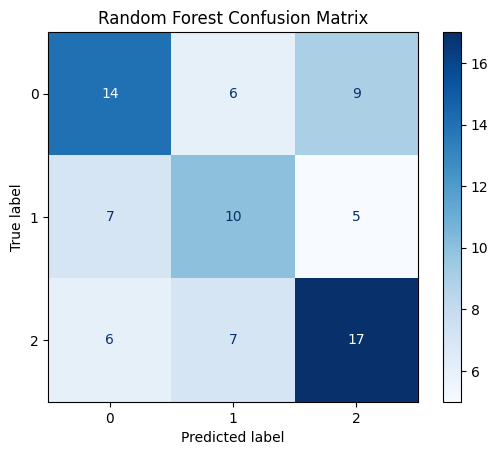

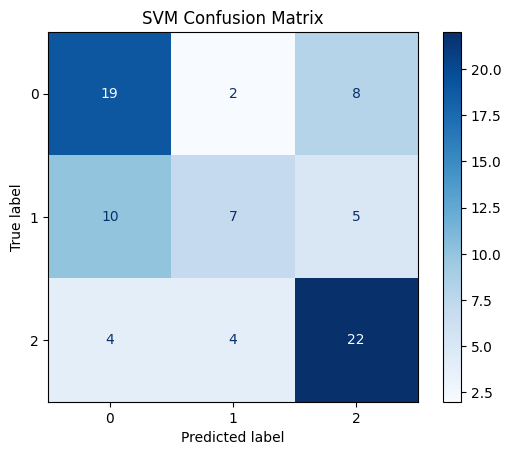

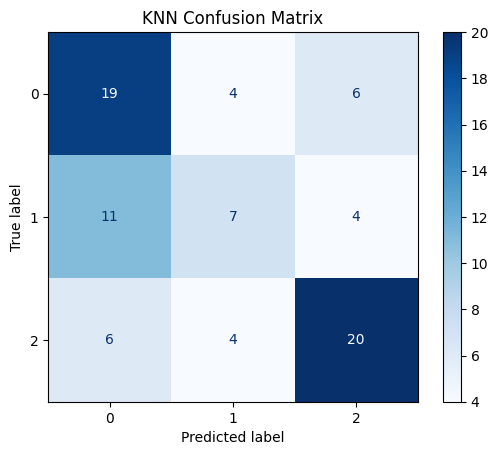

In [66]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, rf.predict(x_test), "Random Forest Confusion Matrix")
# Plot confusion matrix for SVM
plot_confusion_matrix(y_test, svm.predict(x_test), "SVM Confusion Matrix")
# Plot confusion matrix for KNN
plot_confusion_matrix(y_test, knn.predict(x_test), "KNN Confusion Matrix")